In [16]:
%matplotlib inline

In [17]:
# %load source/estimate_impact.py
# Estimate the impact of using OddsCheck
import numpy as np
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing 
import sys
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.pipeline import Pipeline
from source.utils import ProjectsData
import warnings
warnings.filterwarnings('ignore')
import random
random.seed(55)

# fname = 'data_csv/projects/projects.csv.ab'
fname = 'data/opendata_projects000.gz'

projects = ProjectsData(fname)
projects.get_data()
# projects.sample(frac = .5)

# Unpickle the fitted pipeline and the model coefs
filename_model = 'models/pipe_logit_lasso_price.pkl'
pipe_price = pickle.load(open(filename_model, 'rb'))
filename_model = 'models/pipe_logit_lasso.pkl'
pipe = pickle.load(open(filename_model, 'rb'))

# Compute Optimal Price
from scipy import optimize
row = projects.df.iloc[[0]]
def expected_payoff(price, row, pipe):
    row.total_price_excluding_optional_support = price
    p_hat = pipe_price.predict_proba(row)[0][1]
    expected = p_hat * price
    return(-expected)

def est_prob(price, row, pipe):
    row.total_price_excluding_optional_support = price
    p_hat = pipe_price.predict_proba(row)[0][1]
    return(p_hat)


row = projects.df.iloc[[0]]
res = optimize.minimize_scalar(expected_payoff, args = (row, pipe), options = {'disp':False})
print(res.x)
price_opt = res.x

df = projects.df
df['p_hat'] = pipe.predict_proba(df)[:, 1]
df['price_oc'] = df.total_price_excluding_optional_support
df.price_oc[df.price_oc > price_opt] = price_opt

df_oc_price = df.copy()
df_oc_price['total_price_excluding_optional_support'] = df.price_oc
df['p_hat_oc'] = pipe.predict_proba(df_oc_price)[:, 1]

df['exp_payoff'] = df['total_price_excluding_optional_support'] * df['p_hat']
df['payoff'] = df['funded'] * df['total_price_excluding_optional_support']
df['exp_payoff_oc'] = df['price_oc'] * df['p_hat_oc']

total_payoff = df.payoff.sum()
total_exp_payoff = df.exp_payoff.sum()
total_exp_payoff_oc = df.exp_payoff_oc.sum()

print(total_payoff)
print(total_exp_payoff)
print(total_exp_payoff_oc)


removed the recent dates with incomplete projects
(1192072, 44)
Initial size of data
(1192072, 44)
Size of data after removing unnecessary columns apriori
(1192072, 19)
The following columns have > 5% missing and are dropped
Index(['school_metro', 'secondary_focus_area'], dtype='object')
(1192072, 17)
Removing outliers
(1191899, 17)
Remove any rows with missing values
(1191771, 17)
2078.84477348
406626843.7301048
291778061.6101629
295297206.4637889


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

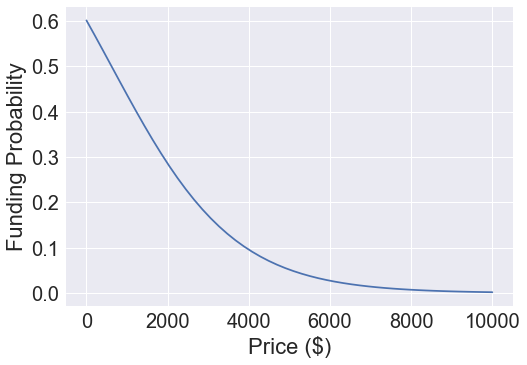

In [19]:
prices = np.linspace(1, 10001)
est_p = np.array(list(map(lambda x: est_prob(x, row, pipe), prices)))
sns.set(font_scale = 2)
plt.plot(prices, est_p)
plt.xlabel('Price ($)')
plt.ylabel('Funding Probability')
plt.savefig('figures/funding_probability.png')

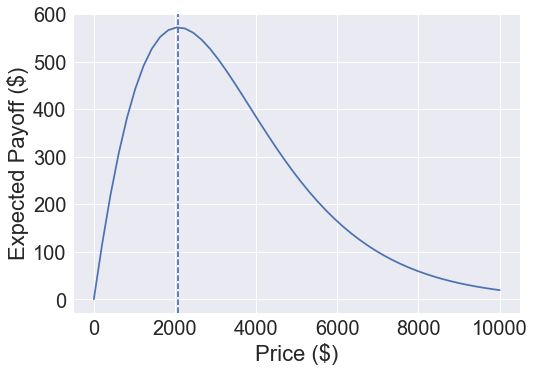

In [37]:
prices = np.linspace(1, 10001)
exp_payoffs = -np.array(list(map(lambda x: expected_payoff(x, row, pipe), prices)))
sns.set(font_scale = 2)
plt.plot(prices, exp_payoffs)
plt.xlabel('Price ($)')
plt.ylabel('Expected Payoff ($)')
plt.axvline(x = price_opt, linestyle = 'dashed')
plt.savefig('figures/funding_expectation.png')


(array([  1.19177000e+06,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([        0. ,   1025001.7,   2050003.4,   3075005.1,   4100006.8,
          5125008.5,   6150010.2,   7175011.9,   8200013.6,   9225015.3,
         10250017. ]),
 <a list of 10 Patch objects>)

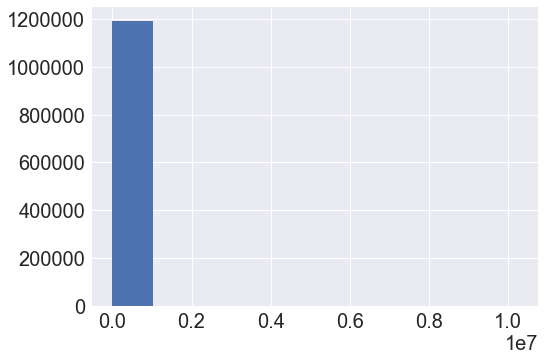

In [21]:
plt.hist(df.total_price_excluding_optional_support)



(array([   6803.,    4051.,    7065.,   25968.,   30183.,   46105.,
         137971.,  311436.,  496715.,  125474.]),
 array([ 0.        ,  0.06591287,  0.13182574,  0.19773862,  0.26365149,
         0.32956436,  0.39547723,  0.4613901 ,  0.52730298,  0.59321585,
         0.65912872]),
 <a list of 10 Patch objects>)

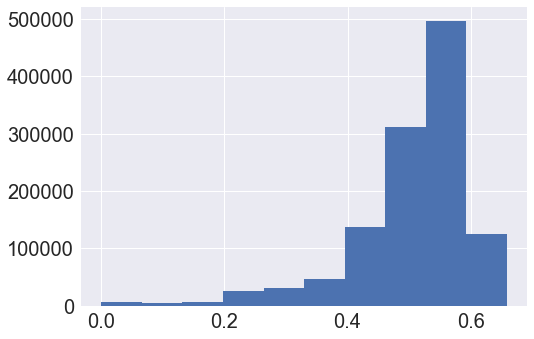

In [22]:
#df[df.total_price_excluding_optional_support > 5000]
p_hats = pipe.predict_proba(df)[:, 1]
plt.hist(p_hats)


In [23]:
df[df.total_price_excluding_optional_support > 5000]
#df[df.total_price_excluding_optional_support < 500]

,school_state,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_prefix,teacher_teach_for_america,teacher_ny_teaching_fellow,...,grade_level,total_price_excluding_optional_support,students_reached,funded,p_hat,price_oc,p_hat_oc,exp_payoff,payoff,exp_payoff_oc
216,NY,f,f,f,f,f,f,Ms.,f,f,...,Grades 9-12,11500.00,0.0,True,1.851967e-04,2078.844773,0.234296,2.129762e+00,11500.00,487.064641
464,NY,f,f,f,f,f,f,Ms.,t,f,...,Grades 6-8,18700.00,0.0,True,6.432873e-07,2078.844773,0.234296,1.202947e-02,18700.00,487.064641
486,NY,f,f,f,f,f,f,Mr.,t,f,...,Grades 3-5,7450.00,0.0,True,5.559863e-03,2078.844773,0.276434,4.142098e+01,7450.00,574.664260
754,NY,f,f,f,f,f,f,Ms.,f,f,...,Grades PreK-2,20000.00,0.0,True,2.672716e-07,2078.844773,0.261132,5.345432e-03,20000.00,542.852722
769,NY,f,f,f,f,f,f,Mr.,f,f,...,Grades 9-12,6160.25,0.0,True,1.266215e-02,2078.844773,0.241149,7.800200e+01,6160.25,501.312029
778,NY,f,f,f,f,f,f,Mr.,f,f,...,Grades PreK-2,9894.00,0.0,True,6.546237e-04,2078.844773,0.234296,6.476847e+00,9894.00,487.064641
884,NY,f,f,f,f,f,f,Ms.,f,f,...,Grades 3-5,9312.00,0.0,True,1.034239e-03,2078.844773,0.234296,9.630831e+00,9312.00,487.064641
1668,NY,f,f,f,f,f,f,Ms.,f,f,...,Grades 3-5,5914.25,0.0,True,1.701293e-02,2078.844773,0.261132,1.006187e+02,5914.25,542.852722
1763,NY,f,f,f,f,f,f,Mrs.,f,f,...,Grades 6-8,7434.02,0.0,True,4.648806e-03,2078.844773,0.239638,3.455932e+01,7434.02,498.170517
2028,NY,f,f,f,f,f,f,Ms.,f,f,...,Grades 3-5,1000000.00,0.0,False,0.000000e+00,2078.844773,0.261132,0.000000e+00,0.00,542.852722


In [24]:
projects.df['funded'].mean()

0.66691587561704391

In [25]:
(projects.df['total_price_excluding_optional_support'] > 2000).mean()

0.027959230422623139

In [31]:
(projects.df['total_price_excluding_optional_support'] > 10000).sum()

1159

In [33]:
df_out = projects.df[projects.df['total_price_excluding_optional_support'] > 10000]
df_out['funded'].mean()

0.35979292493528903

In [34]:
projects.df.shape

(1191771, 23)